In [80]:
# Import the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

import copy
from numpy.linalg import inv
from pandas_datareader.data import DataReader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from scipy.optimize import root
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import *

In [81]:
data = pd.read_excel('Assignment 2 Data.xlsx', sheet_name='Condensed (final) data', engine='openpyxl')

#make the date the index
data.set_index('Date', inplace=True)
data['PCEPI'] = data['PCEPI'] /100 # Male the inflation index with base 1 instead of 100
industries = data.iloc[:,6:].columns
industry_names = industries.tolist()
industry_names

nominal_vars = data[industry_names + ['GDP' , 'M1SL' , 'M2SL']]

real_vars = pd.DataFrame()

for var in nominal_vars.columns:
    real_vars[var] = nominal_vars[var] / data['PCEPI']

real_vars['PCEPI'] = data['PCEPI']

In [88]:
nan_counts = real_vars.isna().sum()
print(nan_counts)


S5TELS Index      1
S5ENRS Index      1
S5INFT Index      1
S5INDU Index      1
S5FINL Index      1
S5MATR Index      1
S5CONS Index      1
S5COND Index      1
S5HLTH Index      1
S5UTIL Index      1
S5RLST Index    119
GDP               2
M1SL              1
M2SL              1
PCEPI             1
dtype: int64


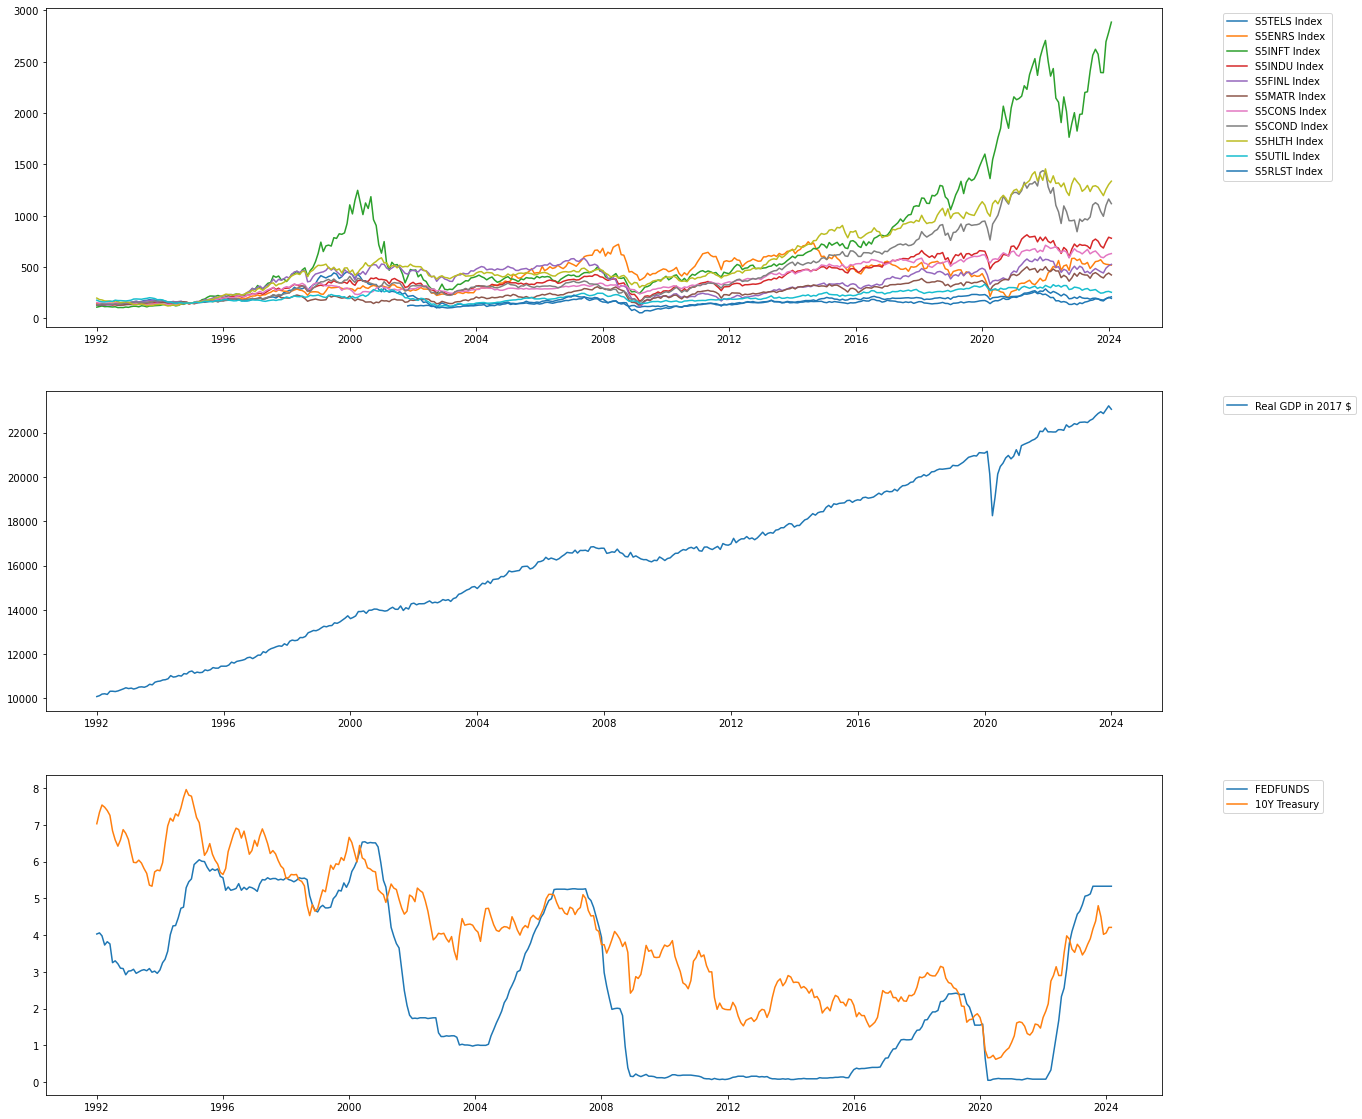

In [85]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(311)
ax.plot(real_vars.index, real_vars[industry_names])
ax.legend(real_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(312)
ax.plot(real_vars.index, real_vars['GDP'])
ax.legend(['Real GDP in 2017 $'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(313)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [90]:
#this is just to make ADF test work but it deletes 100+ obs
real_vars.dropna(inplace=True)

In [93]:
for industry in industry_names:
    result = adfuller(real_vars[industry], regression='c') #Perform ADF test with no constant and no trend
    adf_statistic = result[0]
    p_value = result[1]
    print('\n' + industry + ':')
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)

result_1 = adfuller(real_vars['GDP'], regression='ct') #No constant and no trend
adf_statistic = result_1[0]
p_value = result_1[1]
print('\nReal GDP Growth Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

result_2 = adfuller(data['FEDFUNDS'], regression='c') #Restricted constant but no trend
adf_statistic = result_2[0]
p_value = result_2[1]
print('\nFed Funds Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

result_3 = adfuller(data['10Y Treasury'], regression='c') # 10 year treasury is not stationary
adf_statistic = result_3[0]
p_value = result_3[1]
print('\n10Y Treasury Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)


S5TELS Index:
ADF Statistic: -3.9365065605273757
p-value: 0.0017820154031391085

S5ENRS Index:
ADF Statistic: -2.3112256264751134
p-value: 0.16837304018498395

S5INFT Index:
ADF Statistic: 1.7880985210710871
p-value: 0.9983251179725461

S5INDU Index:
ADF Statistic: -0.5157491848535604
p-value: 0.8889063337753749

S5FINL Index:
ADF Statistic: -1.8890073268987426
p-value: 0.3372499503675319

S5MATR Index:
ADF Statistic: -1.3617551748035726
p-value: 0.600467720804912

S5CONS Index:
ADF Statistic: -0.282126654853231
p-value: 0.9279978636598909

S5COND Index:
ADF Statistic: -0.3337122448872325
p-value: 0.9205920994875604

S5HLTH Index:
ADF Statistic: 0.10590244518488946
p-value: 0.9664617785292859

S5UTIL Index:
ADF Statistic: -1.1276530775403184
p-value: 0.7039191598037599

S5RLST Index:
ADF Statistic: -1.8745958797291908
p-value: 0.34410474173698213

Real GDP Growth Rate:
ADF Statistic: -2.1415758224547465
p-value: 0.5227508372518028

Fed Funds Rate:
ADF Statistic: -2.741263296170783
p-v

In [ ]:
log_vars = np.log(real_vars)

#Take a log difference of the data
log_diff = log_vars.copy().diff().dropna() * 100
treated_vars = log_diff
treated_vars[['FEDFUNDS', '10Y Treasury']] = data[['FEDFUNDS', '10Y Treasury']]
treated_vars

,S5TELS Index,S5ENRS Index,S5INFT Index,S5INDU Index,S5FINL Index,S5MATR Index,S5CONS Index,S5COND Index,S5HLTH Index,S5UTIL Index,S5RLST Index,GDP,M1SL,M2SL,PCEPI,FEDFUNDS,10Y Treasury
Date,,,,,,,,,,,,,,,,,
2001-12-01,1.885393,-4.182402,15.840104,8.929262,6.838158,11.084605,2.247664,12.793370,4.714355,-5.897538,4.566447,1.662140,1.139900,1.083610,-0.103446,1.82,5.09
2002-01-01,1.577316,5.041631,-2.063781,4.191787,1.908484,-2.630433,0.405566,2.276174,-3.398532,2.176884,0.157157,0.215537,0.541684,0.282702,0.090189,1.73,5.04
2002-02-01,-8.662461,-2.093888,1.191920,-5.623455,-1.960351,1.694999,0.874899,-1.064041,-1.205773,-6.302689,-4.781511,-0.521107,-0.176623,0.367548,0.168224,1.74,4.91
2002-03-01,-6.931376,3.595068,-15.397412,2.023128,-1.880041,4.578881,3.634914,0.919173,-0.017084,-2.974813,0.309450,0.339305,-0.044428,-0.055984,0.270947,1.73,5.28
2002-04-01,-2.600816,6.009041,5.584043,1.066541,5.904632,2.821500,2.807027,1.363774,-0.271270,10.825163,2.726182,-0.014005,-0.955308,-0.413898,0.417537,1.75,5.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,-0.783048,0.880702,-1.844824,-2.671607,-3.288122,-3.899643,-4.276531,-1.691750,-1.189495,-7.336765,-3.573857,0.349740,-1.045064,-0.640392,0.383361,5.33,4.38
2023-10-01,-3.358458,2.400462,-7.193448,-6.285887,-3.333706,-5.216114,-4.947944,-6.232312,-3.187784,-6.046748,-8.177669,-0.366227,-0.470277,-0.089689,0.034628,5.33,4.80
2023-11-01,-2.012217,-6.257863,-0.058829,-3.003099,-2.648570,-3.257212,-1.369474,-4.600982,-3.380770,1.229859,-2.965509,0.787509,-0.304085,0.137215,-0.010717,5.33,4.50


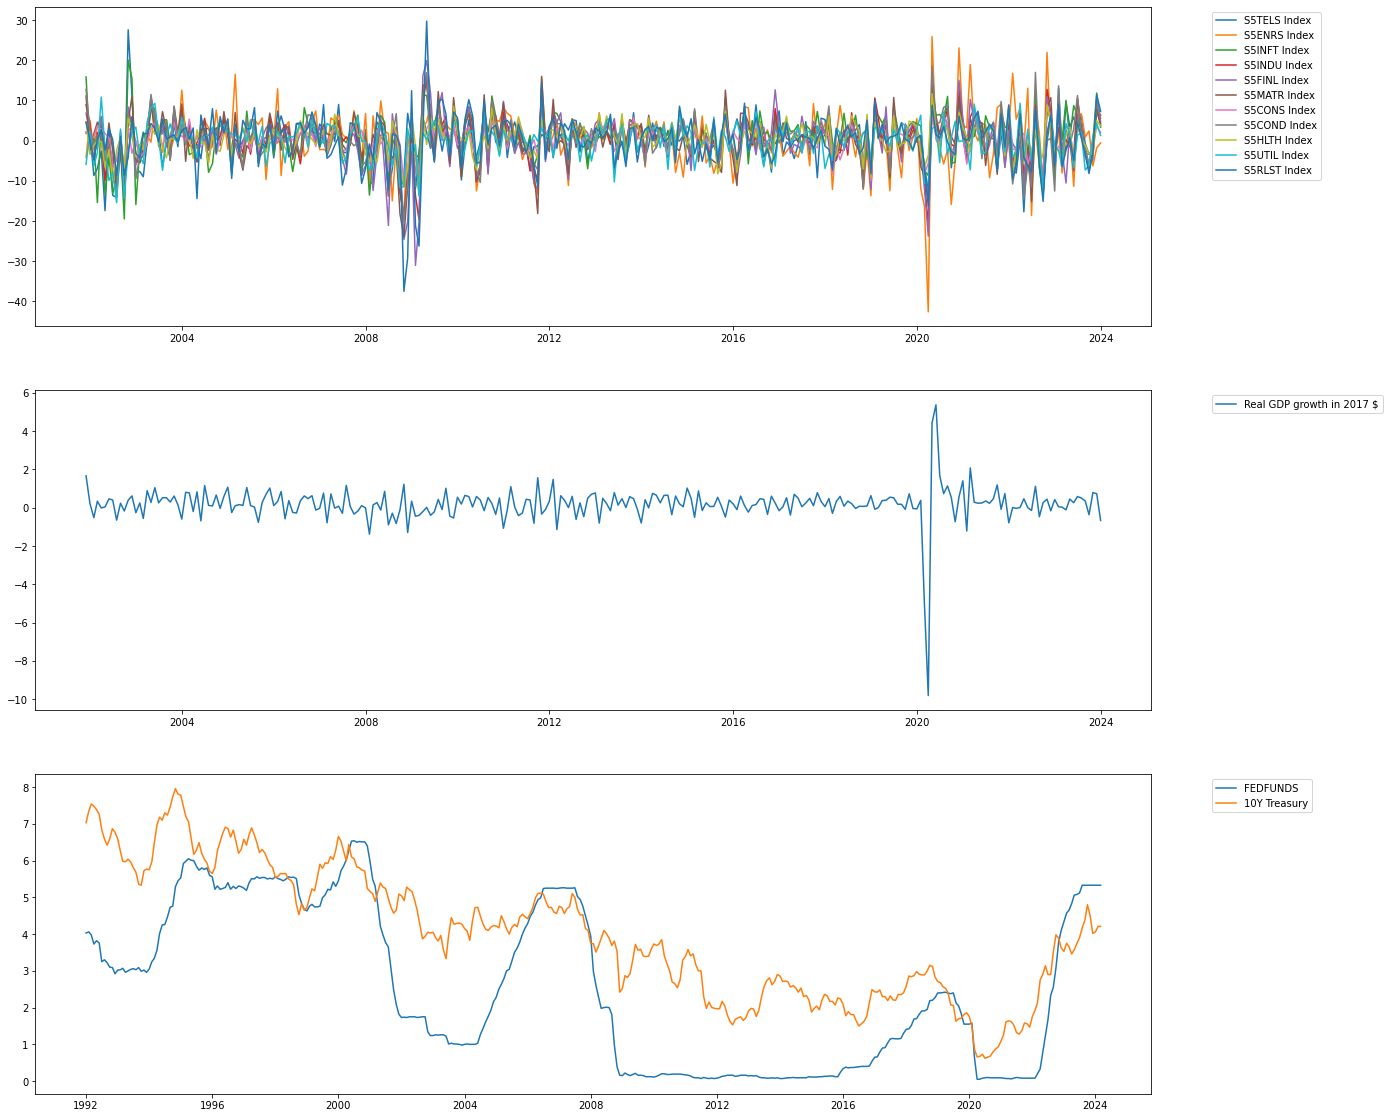

In [ ]:
plt.figure(figsize=(20, 20))
ax = plt.subplot(311)
ax.plot(treated_vars.index, treated_vars[industry_names])
ax.legend(treated_vars[industry_names].columns, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(312)
ax.plot(treated_vars.index, treated_vars['GDP'])
ax.legend(['Real GDP growth in 2017 $'], bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.subplot(313)
ax.plot(data.index, data[['FEDFUNDS', '10Y Treasury']])
ax.legend(['FEDFUNDS', '10Y Treasury'], bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
for industry in industry_names:
    result = adfuller(treated_vars[industry], regression='nc') #Perform ADF test with no constant and no trend
    adf_statistic = result[0]
    p_value = result[1]
    print('\n' + industry + ':')
    print("ADF Statistic:", adf_statistic)
    print("p-value:", p_value)

result_1 = adfuller(treated_vars['GDP'], regression='nc') #No constant and no trend
adf_statistic = result_1[0]
p_value = result_1[1]
print('\nReal GDP Growth Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

result_2 = adfuller(treated_vars['FEDFUNDS'], regression='c') #Restricted constant but no trend
adf_statistic = result_2[0]
p_value = result_2[1]
print('\nFed Funds Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)

result_3 = adfuller(treated_vars['10Y Treasury'], regression='c') # 10 year treasury is not stationary
adf_statistic = result_3[0]
p_value = result_3[1]
print('\n10Y Treasury Rate:')
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)



S5TELS Index:
ADF Statistic: -5.080127717556999
p-value: 7.355015031142121e-07

S5ENRS Index:
ADF Statistic: -17.599146745572863
p-value: 7.43088844845314e-29

S5INFT Index:
ADF Statistic: -16.215437452205393
p-value: 6.253924818312673e-28

S5INDU Index:
ADF Statistic: -6.4001809728209675
p-value: 1.2874412548138181e-09

S5FINL Index:
ADF Statistic: -6.715468954592724
p-value: 2.607104362180025e-10

S5MATR Index:
ADF Statistic: -6.0944946059189
p-value: 5.907619593400491e-09

S5CONS Index:
ADF Statistic: -13.09964694491268
p-value: 7.317773642907982e-24

S5COND Index:
ADF Statistic: -4.89197335183274
p-value: 1.7151890362129415e-06

S5HLTH Index:
ADF Statistic: -4.674932336520321
p-value: 4.4556772775369e-06

S5UTIL Index:
ADF Statistic: -12.572958732336001
p-value: 6.125471391223811e-23

S5RLST Index:
ADF Statistic: -6.642489733014716
p-value: 3.7808884224599553e-10

Real GDP Growth Rate:
ADF Statistic: -13.690800904768327
p-value: 7.977071531968514e-25

Fed Funds Rate:
ADF Statistic